In [1]:
!nvidia-smi

Thu Feb  6 13:54:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
%pwd

'/content'

In [6]:
%cd /content/drive/MyDrive/classes/Detectron2

/content/drive/MyDrive/classes/Detectron2


In [7]:
!pwd

/content/drive/MyDrive/classes/Detectron2


In [8]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/images/
 extracting: data/images/01272020-Kawasaki-Ninja-650-4411-633x388.jpg  
  inflating: data/images/1.jpg       
  inflating: data/images/106036.jpg  
  inflating: data/images/1171297-slow-motion-timelapse-city-cars-traffic-wide-road-vehicles-day-stock-video-footage-videoblocks-wide-road-png-1920_1080_preview.png  
 extracting: data/images/1280px-German_Shepherd_Dog_with_disc.jpg  
  inflating: data/images/14-german-shepherd-CruftsChannel4.jpg  
  inflating: data/images/177961-may23-helmet.jpg  
  inflating: data/images/300px-I-80_Eastshore_Fwy.jpg  
  inflating: data/images/30_07_2018-helmateddn_18257838_9831516.jpg  
  inflating: data/images/3451e49fa7e5f3584138c4cbb983112e.jpg  
  inflating: data/images/3600 (1).jpg  
  inflating: data/images/3600.jpg    
  inflating: data/images/animals_hero_koala02 copy.jpg  
  inflating: data/images/assortment-of-colorful-ripe-tropical-fruits-top-royalty-free-image-995518546-1564092355.

In [9]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("sample", {}, "./data/trainval.json", "./data/images")

In [10]:
sample_metadata = MetadataCatalog.get("sample")
dataset_dicts = DatasetCatalog.get("sample")

WARNING [02/06 14:02:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/06 14:02:43 d2.data.datasets.coco]: Loaded 51 images in COCO format from ./data/trainval.json


In [ ]:
# dataset_dicts

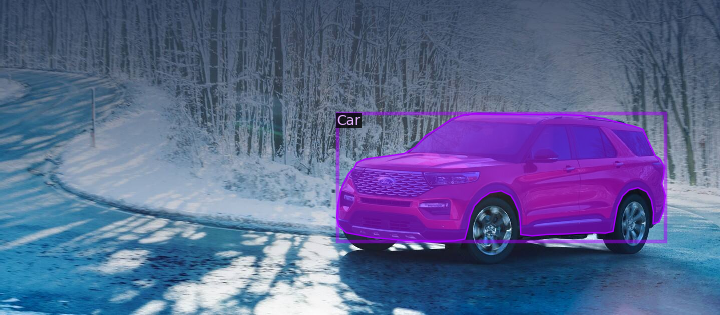

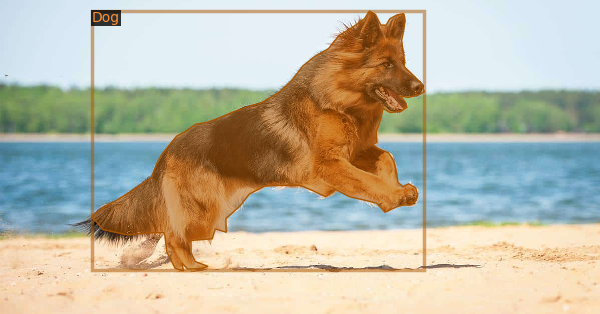

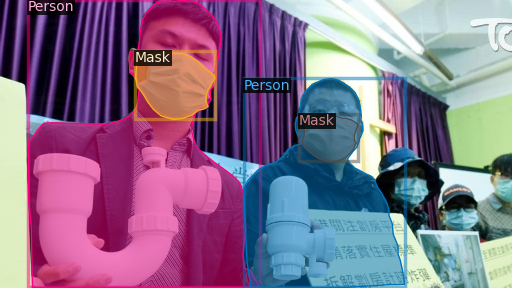

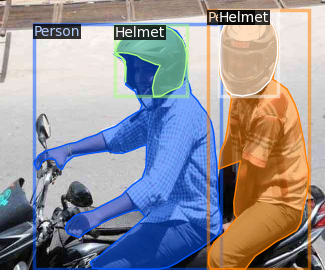

In [11]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [12]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sample",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/06 14:04:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 213MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[02/06 14:04:48 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/06 14:05:02 d2.utils.events]:  eta: 0:02:20  iter: 19  total_loss: 3.847  loss_cls: 2.547  loss_box_reg: 0.5295  loss_mask: 0.6895  loss_rpn_cls: 0.04744  loss_rpn_loc: 0.01198    time: 0.5018  last_time: 0.3817  data_time: 0.0247  last_data_time: 0.0037   lr: 0.00016068  max_mem: 2670M
[02/06 14:05:16 d2.utils.events]:  eta: 0:02:10  iter: 39  total_loss: 2.123  loss_cls: 0.8452  loss_box_reg: 0.6207  loss_mask: 0.6483  loss_rpn_cls: 0.009212  loss_rpn_loc: 0.008652    time: 0.5040  last_time: 0.4803  data_time: 0.0267  last_data_time: 0.0059   lr: 0.00032718  max_mem: 2670M
[02/06 14:05:25 d2.utils.events]:  eta: 0:01:55  iter: 59  total_loss: 1.925  loss_cls: 0.7519  loss_box_reg: 0.6376  loss_mask: 0.5135  loss_rpn_cls: 0.02433  loss_rpn_loc: 0.0104    time: 0.4882  last_time: 0.4741  data_time: 0.0072  last_data_time: 0.0064   lr: 0.00049367  max_mem: 2670M
[02/06 14:05:35 d2.utils.events]:  eta: 0:01:47  iter: 79  total_loss: 1.729  loss_cls: 0.6051  loss_box_reg: 0.6557  los

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("sample", )
predictor = DefaultPredictor(cfg)

[02/06 14:08:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [17]:
%pwd

'/content/drive/MyDrive/classes/Detectron2'

In [18]:
!ls

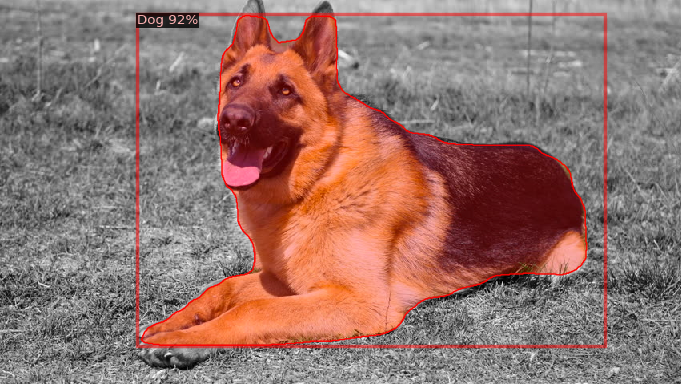

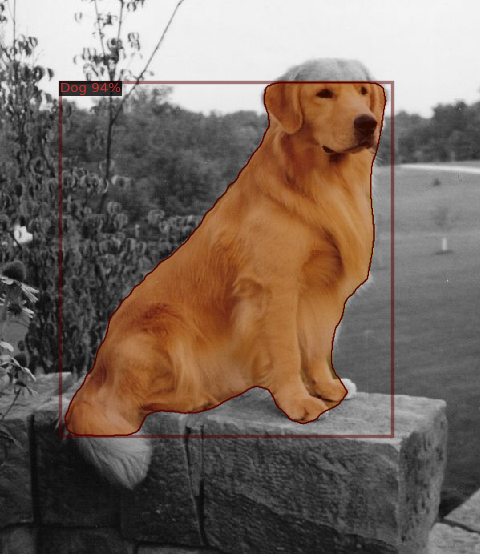

In [22]:
from detectron2.utils.visualizer import ColorMode
import os

data_path = "/content/drive/MyDrive/classes/Detectron2/test_data/"

for d in os.listdir("test_data"):
    im = cv2.imread(data_path + d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

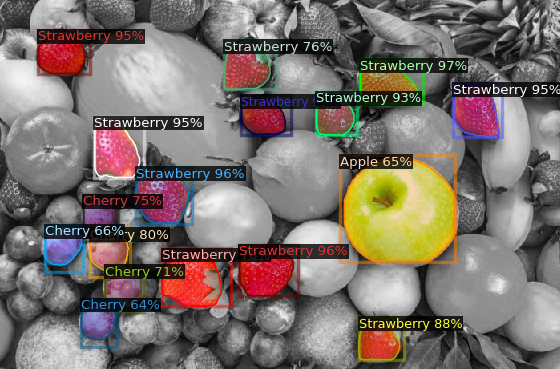

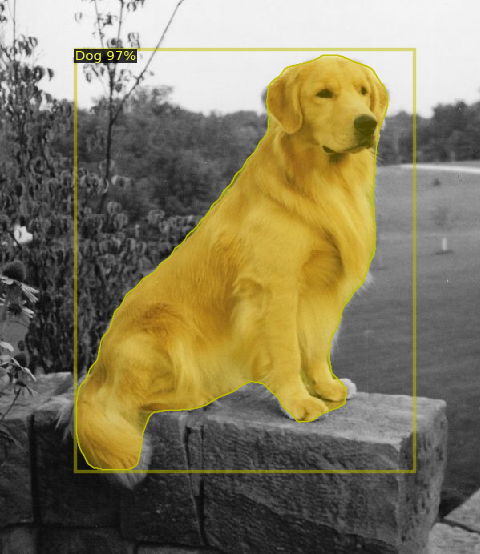

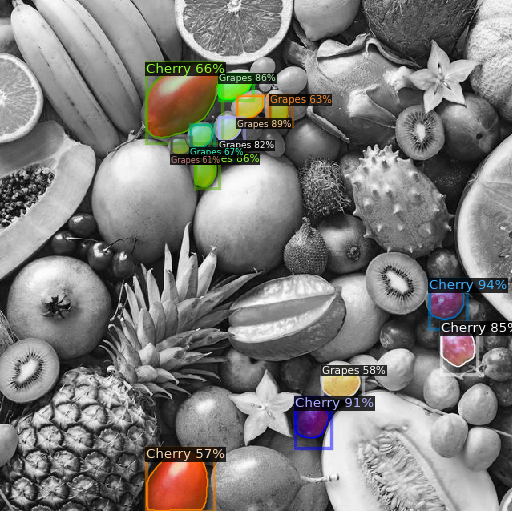

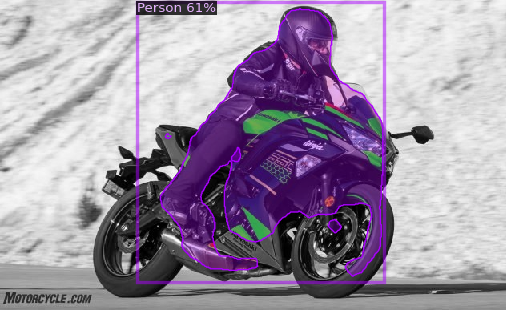

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

# Evaluation

In [23]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("sample", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "sample")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [02/06 14:12:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/06 14:12:05 d2.data.datasets.coco]: Loaded 51 images in COCO format from ./data/trainval.json
[02/06 14:12:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/06 14:12:05 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/06 14:12:05 d2.data.common]: Serializing 51 elements to byte tensors and concatenating them all ...
[02/06 14:12:05 d2.data.common]: Serialized dataset takes 0.13 MiB
[02/06 14:12:05 d2.evaluation.evaluator]: Start inference on 51 batches
[02/06 14:12:07 d2.evaluation.evaluator]: Inference done 11/51. Dataloading: 0.0016 s/iter. Inference: 0.1195 s/iter. Eval: 0.0028 s/iter. Total: 0.1239 s/iter. ETA=0:00:04
[02/06 14:12:12 d2.evaluation.evaluator]: Inference

## Getting the custom config file

In [ ]:
pwd

'/content/drive/MyDrive/Classes/Detectron2'

In [ ]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()